# Embedded ML Lab - Excercise 3 - Pruning

Now we will focus on structured pruning to save computation time. We will do this in three steps.  
* We will implement a function, similar to previous l1 pruning, to sets whole output channels to zero.  

* We will delete the zeroed-out channels and densify the network again to have a reduction in computation time.

* We will retrain the network to gain accuracy again.  



In [1]:
import torch
torch.rand(1).to('cuda') #initialize cuda context (might take a while)

from net import PrunedCifarNet
import torch
from typing import Dict, List
import numpy as np

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
tf = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=False, download=True, transform=tf), shuffle=False, batch_size=32)
trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=tf), shuffle=True, batch_size=32)

Files already downloaded and verified
Files already downloaded and verified


First, we focus on setting the output channels to zero.  
Your Task:
   * Implement the function `l1_structured_pruning`, that takes a `state_dict` and a `prune_ratio` as input. Calculate the l1 norm $||x||_1= \sum_{i=1}^N |x_i|$, of each output channel, and set the output channels with the lowest norm to zero to meet the prune_ratio.
       * Also, for each output channels that is zeroed-out, set the convolution's bias to zero
       * You can keep `conv1` and `conv2` unpruned.

In [2]:
# Test of structured L1 pruning
state_dict = torch.load('state_dict__cifarnet.pt')
for key in state_dict:
    print(key)

# Conv lavers 3-6
for num in range(4):
    # print('conv{}.weight'.format(num+3))
    conv_layer = state_dict.get('conv{}.weight'.format(num+3))
    
    # L1 norm of each output channels + mask
    out_channels_num = conv_layer.shape[0]
    out_channel_l1_norm = torch.zeros(conv_layer.shape[0])
    for out_channel in range(out_channels_num):
        out_channel_l1_norm[out_channel] = conv_layer[out_channel].cpu().abs().sum().item()

    threshold = np.percentile(out_channel_l1_norm.cpu().numpy(), 50)
    conv_mask = torch.where(out_channel_l1_norm<threshold, 0.0, 1.0)

    # Zero out the pruned channels
    for idx, keep in enumerate(conv_mask):
        if keep != 1.0:
            state_dict['conv{}.weight'.format(num+3)][idx] = 0
            state_dict['conv{}.bias'.format(num+3)][idx] = 0
            # conv_layer[idx] = 0

    # print(conv_mask)
    # print(state_dict['conv{}.weight'.format(num+3)])
    # print(state_dict['conv{}.bias'.format(num+3)])

conv1.weight
conv1.bias
conv2.weight
conv2.bias
conv3.weight
conv3.bias
conv4.weight
conv4.bias
conv5.weight
conv5.bias
conv6.weight
conv6.bias
fc.weight
fc.bias


In [2]:
def l1_structured_pruning(state_dict: Dict, prune_ratio: float) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    #---to be done by student---
    # conv layer 3-6
    for num in range(4):
        conv_layer = state_dict.get('conv{}.weight'.format(num+3))
        
        # L1 norm of each output channels + mask
        out_channels_num = conv_layer.shape[0]
        out_channel_l1_norm = torch.zeros(conv_layer.shape[0])
        for out_channel in range(out_channels_num):
            out_channel_l1_norm[out_channel] = conv_layer[out_channel].cpu().abs().sum().item()
    
        threshold = np.percentile(out_channel_l1_norm.cpu().numpy(), prune_ratio*100)
        conv_mask = torch.where(out_channel_l1_norm<threshold, 0.0, 1.0)
    
        # Zero out the pruned channels
        for idx, keep in enumerate(conv_mask):
            if keep != 1.0:
                state_dict['conv{}.weight'.format(num+3)][idx] = 0
                state_dict['conv{}.bias'.format(num+3)][idx] = 0
    #---end---------------------
    return state_dict

We now iteratively test the function for several pruning ratios. Right now, we get no gains in MACs (Multiply-accumulate operations), since the values are just set to zero.

100%|███████████████████████████████████████████| 15/15 [01:16<00:00,  5.13s/it]


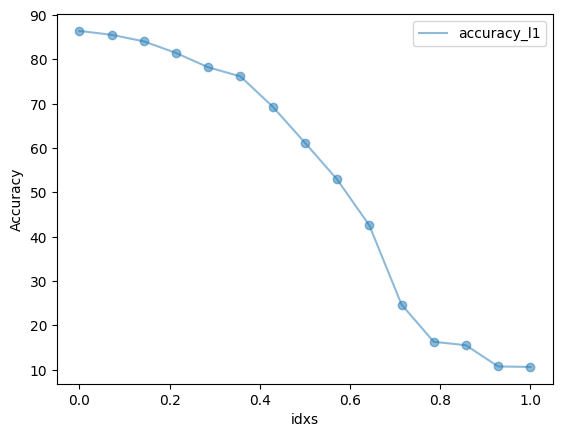

In [3]:
import tqdm
import copy

from utils import net_acc, net_time, net_macs, plot

ratios = np.linspace(0, 0.8, 15)

state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_l1, idxs = [], []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    accuracy_l1.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))
    idxs.append(idx)
plot([(idxs, accuracy_l1, 'accuracy_l1')], xlabel='idxs', save_path='accuracy_l1.png')

Next, we implement a function that removes the zeroed-out output channels to gain actual inference speed ups.

Your Tasks:
* For each `weight` tensor of conv2d layers, slice the tensor such that only the output channels with non-zero filters remain.
* If an output channel is removed, also remove its respective bias.
* For each consecutive conv layer, remove the input channels that are zeroed-out output channels of the previous conv layer   
* TIP: A tensor containing channels can be reshaped using a list of indices (e.g., `new_tensor = tensor[[1,2,3,5,6,7],:,:,:]` 
* For the last conv2d layer, you have to consider the flattened  output and slice the input of the fully connected layer. In the case of the `CifarNet` we currently use, the feature map before being flatted is $2\times 2$ with $256$ output channels, where `torch.flatten` arranges the channels starting with index $0$.

As a help, check the image: Each pruned output filter (gray/vertical) appears as a pruned input (red/horizontal) in the consecutive conv layer.  
<img src="src/prune.png" alt="drawing" width="700"/>

In [5]:
# Test of structured L1 pruning + densify
state_dict = torch.load('state_dict__cifarnet.pt')
state_dict = l1_structured_pruning(state_dict, 0.2)

print("Before")
for key in state_dict:
    print(key)
    print(state_dict[key].shape)

# Conv lavers 3-6
for num in range(4):
    # print('conv{}.weight'.format(num+3))
    conv_layer = state_dict.get('conv{}.weight'.format(num+3))
    conv_bias = state_dict.get('conv{}.bias'.format(num+3))
    
    # Calc L1 norm of all output channels
    idxs = []
    out_channels_num = conv_layer.shape[0]
    for out_channel in range(out_channels_num):
        out_channel_l1_norm = conv_layer[out_channel].cpu().abs().sum().item()

        # get indices of not-zeroed out_channels   
        if out_channel_l1_norm != 0:
            idxs.append(out_channel)
    
    conv_layer = conv_layer[idxs,:,:,:]
    conv_bias = conv_bias[idxs]

    # Update state dict
    state_dict['conv{}.weight'.format(num+3)] = conv_layer
    state_dict['conv{}.bias'.format(num+3)] = conv_bias
    
    # Prune input layer of next conv layer
    if num+3 != 6:
        conv_layer_next = state_dict.get('conv{}.weight'.format(num+3+1))
        conv_layer_next = conv_layer_next[:,idxs,:,:]
        state_dict['conv{}.weight'.format(num+3+1)] = conv_layer_next
    

# Fully connected layer
#print(idxs)
idxs_fc = []
for idx in idxs:
    for i in range(4):
        idxs_fc.append(4*idx+i)
    
#print(idxs_fc)
fc_layer = state_dict.get('fc.weight')
#print(fc_layer.shape)
fc_layer = fc_layer[:,idxs_fc]
#print(fc_layer.shape)
state_dict['fc.weight'] = fc_layer

print("\nAfter")
for key in state_dict:
    print(key)
    print(state_dict[key].shape)

Before
conv1.weight
torch.Size([16, 3, 3, 3])
conv1.bias
torch.Size([16])
conv2.weight
torch.Size([32, 16, 3, 3])
conv2.bias
torch.Size([32])
conv3.weight
torch.Size([64, 32, 3, 3])
conv3.bias
torch.Size([64])
conv4.weight
torch.Size([128, 64, 3, 3])
conv4.bias
torch.Size([128])
conv5.weight
torch.Size([256, 128, 3, 3])
conv5.bias
torch.Size([256])
conv6.weight
torch.Size([256, 256, 3, 3])
conv6.bias
torch.Size([256])
fc.weight
torch.Size([10, 1024])
fc.bias
torch.Size([10])

After
conv1.weight
torch.Size([16, 3, 3, 3])
conv1.bias
torch.Size([16])
conv2.weight
torch.Size([32, 16, 3, 3])
conv2.bias
torch.Size([32])
conv3.weight
torch.Size([51, 32, 3, 3])
conv3.bias
torch.Size([51])
conv4.weight
torch.Size([102, 51, 3, 3])
conv4.bias
torch.Size([102])
conv5.weight
torch.Size([205, 102, 3, 3])
conv5.bias
torch.Size([205])
conv6.weight
torch.Size([205, 205, 3, 3])
conv6.bias
torch.Size([205])
fc.weight
torch.Size([10, 820])
fc.bias
torch.Size([10])


In [4]:
def densify_state_dict(state_dict: Dict) -> Dict:
    state_dict = copy.deepcopy(state_dict)
    #---to be done by student---
    # conv layer 3-6
    for num in range(4):
        conv_layer = state_dict.get('conv{}.weight'.format(num+3))
        conv_bias = state_dict.get('conv{}.bias'.format(num+3))
        
        # Calc L1 norm of all output channels
        idxs = []
        out_channels_num = conv_layer.shape[0]
        for out_channel in range(out_channels_num):
            out_channel_l1_norm = conv_layer[out_channel].cpu().abs().sum().item()
    
            # get indices of not-zeroed out-channels   
            if out_channel_l1_norm != 0:
                idxs.append(out_channel)
        
        conv_layer = conv_layer[idxs,:,:,:]
        conv_bias = conv_bias[idxs]
    
        # Update state dict
        state_dict['conv{}.weight'.format(num+3)] = conv_layer
        state_dict['conv{}.bias'.format(num+3)] = conv_bias
        
        # Prune input layer of next conv layer + update state dict
        if num+3 != 6:
            conv_layer_next = state_dict.get('conv{}.weight'.format(num+3+1))
            conv_layer_next = conv_layer_next[:,idxs,:,:]
            state_dict['conv{}.weight'.format(num+3+1)] = conv_layer_next
    

    # Prune input of fully connected layer
    idxs_fc = []
    for idx in idxs:
        # One conv output-channel gets casted onto 4 fc inputs (1024/256=4)
        for i in range(4):
            idxs_fc.append(4*idx+i)
        
    fc_layer = state_dict.get('fc.weight')
    fc_layer = fc_layer[:,idxs_fc]
    state_dict['fc.weight'] = fc_layer
    #---end---------------------
    return state_dict

If you have implemented the `densify_state_dict` function correctly, the plot (orange) should behave exactly the same (orange and blue should overlap).

100%|███████████████████████████████████████████| 15/15 [00:22<00:00,  1.49s/it]


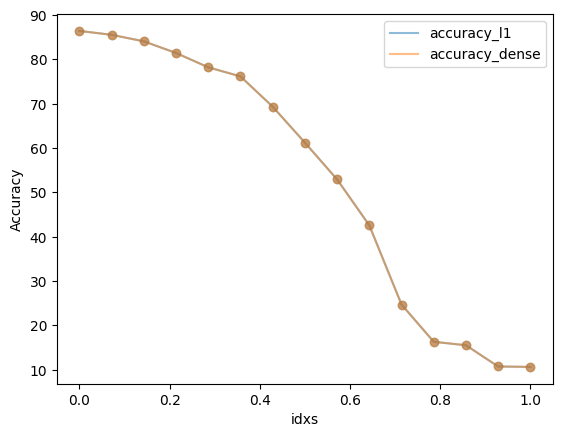

In [5]:
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_dense = []
for idx, ratio in tqdm.tqdm(enumerate(ratios), total=len(ratios)):
    state_dict = l1_structured_pruning(state_dict, ratio)
    sd = densify_state_dict(state_dict)
    accuracy_dense.append(net_acc(PrunedCifarNet, sd, testloader, batches=32, device='cuda'))
plot([(idxs, accuracy_l1, 'accuracy_l1'), (idxs, accuracy_dense, 'accuracy_dense')], xlabel='idxs', save_path='accuracy_l1.png')

Now we implement the last missing pieces to apply iterative pruning. To save time, we only apply changes to the last linear layer, all other layers are frozen.

Your Tasks:
* Implement a training function that takes the `model_class` the `state_dict`, the `trainloader`, the number of batches, and device (cpu/cuda) as input and returns a state_dict as output.

In [6]:
def train(model_class: torch.nn.Module, state_dict: Dict,
          trainloader: torch.utils.data.DataLoader, batches: int=64, device: str='cpu'):

    # Learning rate
    lr = 0.01

    torch_device = torch.device(device)

    model = model_class()
    model.load_state_dict(state_dict)
    model.to(torch_device)

    model.train()
    
    # For all conv layers we disable the calculation of gradients in the backwards step
    for key, param in model.named_parameters():
        if any(x in key for x in ['1', '2', '3', '4', '5', '6']):
            param.requires_grad = False
    # The optimizer gets only the parameters that require gradient calculation
    optimizer = torch.optim.SGD(filter(lambda x: x.requires_grad, model.parameters()), lr=lr)
    
    # Loss function
    loss_f = torch.nn.CrossEntropyLoss()
    

    for idx, (inputs, targets) in enumerate(trainloader):
        #-to-be-done-by-student-----
        inputs = inputs.to(device)
        targets = targets.to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)
    
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
        #---------------------------
    return model.state_dict()

We now iteratively prune some percent and retrain the densified state dict. We therefor use an adaptable `PrunedCifarNet` that changes the layer definition based on the parameters dimensions of the state dict.

Furthermore, we plot two versions: One with fine-tuned parameters, one where no re-training is applied.

100%|███████████████████████████████████████████| 26/26 [19:10<00:00, 44.23s/it]


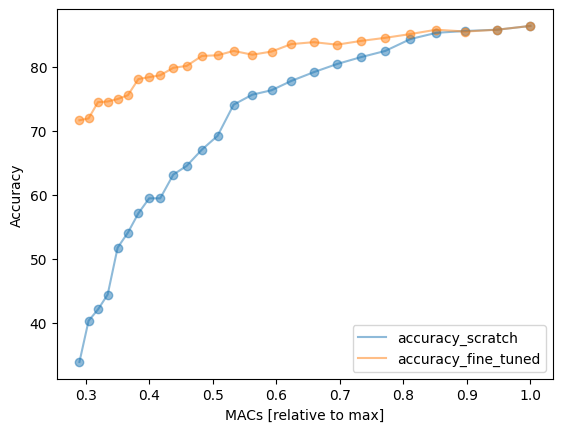

In [7]:
# define ratios
ratios = [0.0] + [0.025 for _ in range(25)]
state_dict = torch.load('state_dict__cifarnet.pt')
accuracy_from_scratch, accuracy_fine_tuned, macs = [], [], []
for ratio in tqdm.tqdm(ratios):
    
    # Setting Filters to zero
    state_dict = l1_structured_pruning(state_dict, ratio)
    
    # Densifying the state dict
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    # Accuracy calculation
    accuracy_from_scratch.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))

#We now do the same with training for comparions (this might take a while)
state_dict = torch.load('state_dict__cifarnet.pt')
for ratio in tqdm.tqdm(ratios):
    state_dict = l1_structured_pruning(state_dict, ratio)
    state_dict = densify_state_dict(copy.deepcopy(state_dict))
    
    #We fine tune the network by training with 150 batches
    state_dict = train(PrunedCifarNet, state_dict, trainloader, batches=32, device='cuda')
    accuracy_fine_tuned.append(net_acc(PrunedCifarNet, state_dict, testloader, batches=32, device='cuda'))
    macs.append(net_macs(PrunedCifarNet, state_dict))
    
    
plot([(macs, accuracy_from_scratch, 'accuracy_scratch'),
      (macs, accuracy_fine_tuned, 'accuracy_fine_tuned')],
      xlabel='MACs [relative to max]', save_path='accuracy_macs.png')